densenet

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 16000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
 

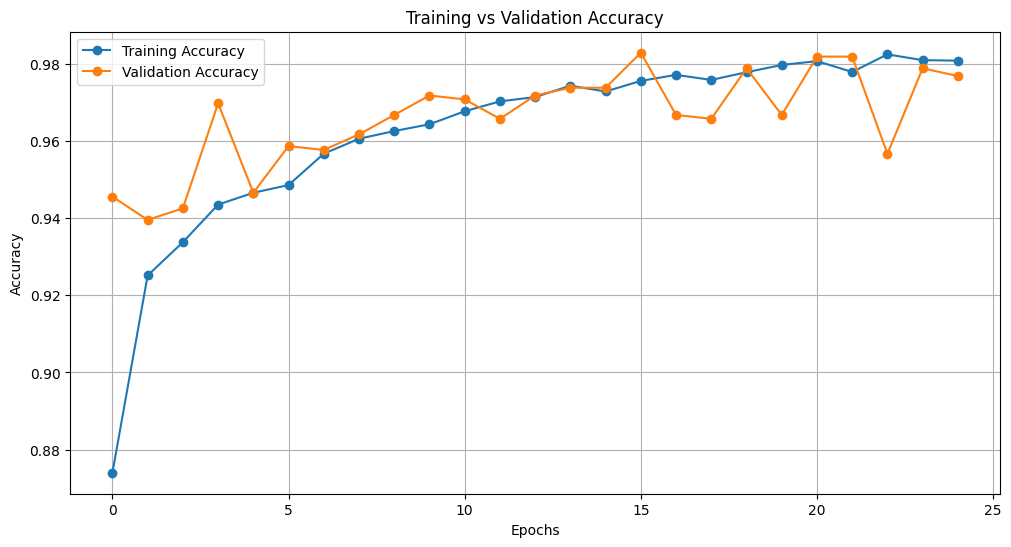

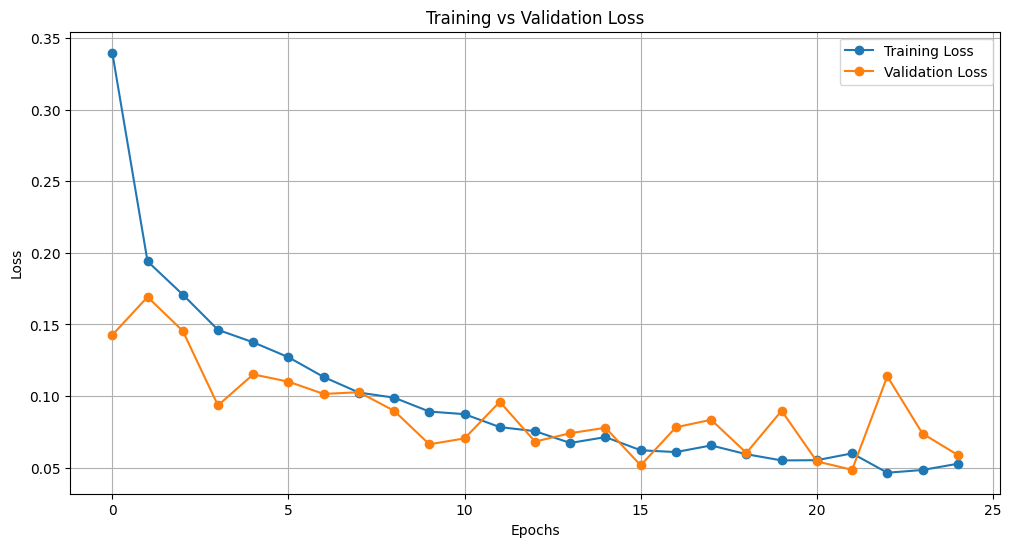

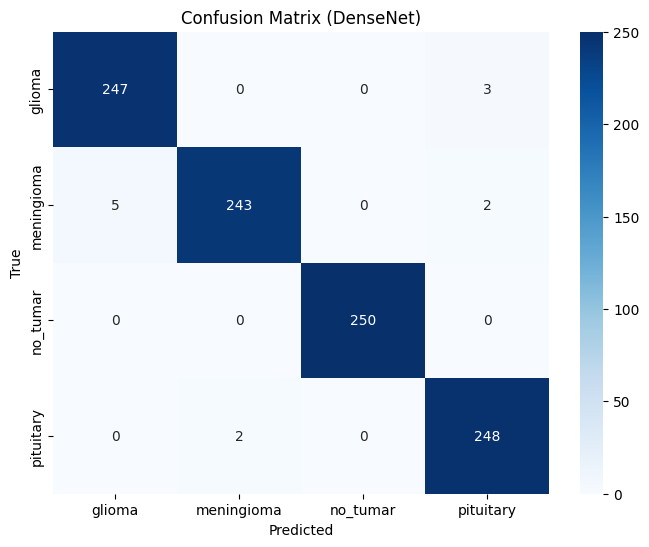

Report has been saved to densenet_report.txt


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define the path to your training, validation, and test data directories
train_data_dir = '/kaggle/input/brain-tumor-sdp/Brain Dataset/train'
val_data_dir = '/kaggle/input/brain-tumor-sdp/Brain Dataset/val'
test_data_dir = '/kaggle/input/brain-tumor-sdp/Brain Dataset/test'

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load and preprocess your dataset
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Record the start time for the entire training process
start_time_total = time.time()

# Implement DenseNet121
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(4, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the DenseNet model
for layer in base_model.layers:
    layer.trainable = False

# Print the model summary
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 25

# Record the start time for DenseNet model training
start_time_densenet = time.time()

# Train the model
train_steps = train_generator.samples // batch_size
val_steps = val_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_steps
)

# Record the end time for the entire training process
end_time_total = time.time()

# Calculate total training time
total_training_time = end_time_total - start_time_total

# Save the model
model.save('densenet_brain_tumor.h5')

# Print and save training times
print(f"Total Training Time: {total_training_time} seconds")
avg_epoch_time = total_training_time / epochs
print(f"Average Time per Epoch: {avg_epoch_time} seconds")

# Use model.evaluate to get test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy}")

# Extract predictions and true labels for confusion matrix
test_pred = np.argmax(model.predict(test_generator), axis=1)
test_true = test_generator.classes

# Calculate and plot the confusion matrix
confusion = confusion_matrix(test_true, test_pred)

# Get the class labels from the generator
class_labels = list(train_generator.class_indices.keys())

# Print confusion matrix
print("Confusion Matrix:")
print(confusion)

# Generate classification report
print("Classification Report:")
classification_rep = classification_report(test_true, test_pred, target_names=class_labels)
print(classification_rep)

# Plot Training Accuracy vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('densenet_accuracy_plot.png')  # Save the accuracy plot

# Plot Training Loss vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('densenet_loss_plot.png')  # Save the loss plot

# Display and save the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (DenseNet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('densenet_confusion_matrix.png')  # Save the confusion matrix plot

# Save all the plots
plt.show()
# Save the report to a text file
report_filename = 'densenet_report.txt'

with open(report_filename, 'w') as file:
    file.write(f"Epochs: {epochs}\n")
    file.write(f"Total Training Time: {total_training_time} seconds\n")
    file.write(f"Average Time per Epoch: {avg_epoch_time} seconds\n")
    file.write(f"Test Accuracy: {test_accuracy}\n")
    file.write("Confusion Matrix:\n")
    np.savetxt(file, confusion, fmt='%4d')  # Writing confusion matrix to file
    file.write("Classification Report:\n")
    file.write(classification_rep)

print(f"Report has been saved to {report_filename}")
